In [185]:
%matplotlib inline
import pandas as pd
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train = None, val = None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'
            ))

data = KaggleHouse(batch_size=32)
print(data.raw_train.shape)
print(data.raw_val.shape)
print(data.raw_train.iloc[:4,[0, 1, 2, 3, -3, -2, -1]])

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


数据预处理

In [186]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    label = 'SalePrice'

    # 1. 分离训练集和测试集（避免数据泄露）
    train_features = self.raw_train.drop(columns=['Id', label])
    val_features = self.raw_val.drop(columns=['Id'])

    # 2. 识别数值特征（仅用于插补）
    numeric_features = train_features.dtypes[train_features.dtypes != 'object'].index

    # 3. 使用KNN插补（仅用训练集拟合，用于训练集和测试集）
    imputer = KNNImputer(n_neighbors=5)  # K=5是常用值

    # 用训练集拟合插补器
    train_imputed = imputer.fit_transform(train_features[numeric_features])
    val_imputed = imputer.transform(val_features[numeric_features])

    # 4. 将插补后的数值特征替换回DataFrame
    train_features[numeric_features] = train_imputed
    val_features[numeric_features] = val_imputed

    # 5. 合并处理后的特征（现在所有数值特征已无缺失）
    features = pd.concat([train_features, val_features])

    # 6. 标准化数值特征（使用训练集的均值和标准差）
    for col in numeric_features:
        mean = train_features[col].mean()
        std = train_features[col].std()
        features[col] = (features[col] - mean) / std

    # 7. 处理分类特征（保留NaN作为独立类别）
    features = pd.get_dummies(features, dummy_na=True)

    # 8. 拆分回训练集和测试集
    n_train = self.raw_train.shape[0]
    self.train = features.iloc[:n_train].copy()
    self.train[label] = self.raw_train[label]
    self.val = features.iloc[n_train:].copy()

data.preprocess()

定义均方对数误差

In [187]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                        dtype=torch.float32)
    tensors = (get_tensor(data.drop(columns=[label])),
               torch.log(get_tensor(data[label])).reshape((-1, 1)))
    return self.get_tensorloader(tensors, train)

实现多层感知机

In [188]:
class MLPRegressor(d2l.Module):
    """MLP 回归模型，使用 Adam 优化器"""
    def __init__(self, num_inputs, lr, num_hiddens_1=128, num_hiddens_2=64, num_hiddens_3=32, weight_decay=0):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens_1),
            nn.ReLU(),
            nn.Linear(num_hiddens_1, num_hiddens_2),
            nn.ReLU(),
            nn.Linear(num_hiddens_2, num_hiddens_3),
            nn.ReLU(),
            nn.Linear(num_hiddens_3, 1)
        )
        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        # 使用均方误差损失
        fn = nn.MSELoss()
        return fn(y_hat, y)

    def configure_optimizers(self):
        # 使用 Adam 优化器
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

K 折交叉

In [189]:
def k_fold_data(data, k):
    rets = []
    n = len(data.train)

    # 打乱索引
    indices = np.random.permutation(n)

    fold_size = n // k
    remainder = n % k

    start = 0
    for j in range(k):
        # 当前 fold 大小：前 remainder 个 fold 多一个样本
        current_size = fold_size + (1 if j < remainder else 0)
        end = start + current_size

        val_indices = indices[start:end]
        train_indices = np.concatenate([indices[:start], indices[end:]])

        val_df = data.train.iloc[val_indices].copy()
        train_df = data.train.iloc[train_indices].copy()

        rets.append(KaggleHouse(data.batch_size, train_df, val_df))
        start = end

    return rets

def k_fold(trainer, data, k, num_inputs, lr=0.01):
    """K 折交叉验证，使用 MLP 模型和 Adam 优化器"""
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        # 使用 MLPRegressor 替代 LinearRegression
        model = MLPRegressor(num_inputs=num_inputs, lr=lr)
        model.board.yscale = 'log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

训练

average validation log mse = 0.025622849776409568


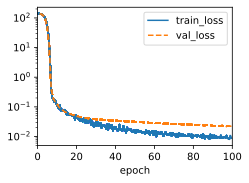

In [190]:
num_inputs = data.train.shape[1] - 1
trainer = d2l.Trainer(max_epochs=100)
models = k_fold(trainer, data, k=5, num_inputs=num_inputs, lr=0.0001)

In [191]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32)) for model in models]
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id': data.raw_val.Id, 'SalePrice': ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)